In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as special

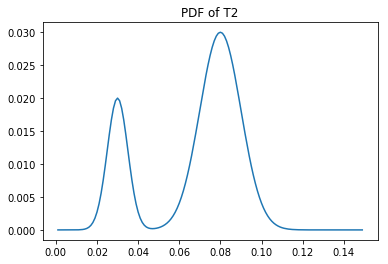

In [6]:
# Data generation

T2_signal         = np.arange(1,150,1)*1e-3;
TE_measurements   = np.arange(10,330,10)*1e-3;
T2_myelin         = 30*1e-3;
T2_ex             = 80*1e-3;
sigma_myelin      = 5*1e-3;
sigma_ex          = 10*1e-3;
A_myelin          = 1;
A_ex              = 3;

y         = A_myelin*np.exp(-(T2_signal-T2_myelin)**2/2/sigma_myelin**2)/np.sqrt(2*np.pi)/sigma_myelin + A_ex*np.exp(-(T2_signal-T2_ex)**2/2/sigma_ex**2)/np.sqrt(2*np.pi)/sigma_ex
y         = y/np.sum(y)

plt.plot(T2_signal,y)
plt.title('PDF of T2')
plt.show()

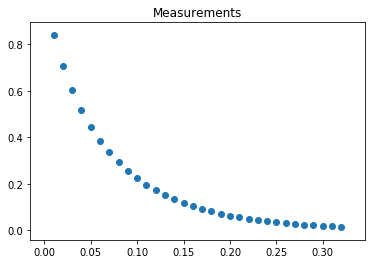

In [7]:
# Measurements simulation

grid    = -TE_measurements.reshape([TE_measurements.size,1])/T2_signal.reshape([1,T2_signal.size])
S       = np.matmul(np.exp(grid),y)

plt.scatter(TE_measurements,S)
plt.title('Measurements')
plt.show()

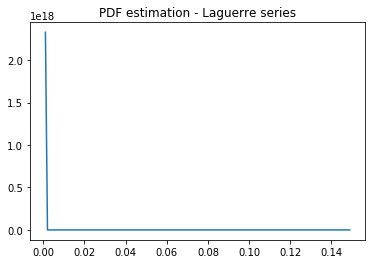

In [10]:
#------ Approximation 1 - Laguerre series --------

# q estimation
regul = 1;
H     = np.zeros([TE_measurements.size, TE_measurements.size])
nn    = np.arange(0,TE_measurements.size)

for i,TE in enumerate(TE_measurements):
    H[i,:] = ((TE-1)**nn)/(TE**(nn+1))

q = np.matmul(np.linalg.inv(np.matmul(H.transpose(),H)+regul*np.identity(TE_measurements.size)),np.matmul(H.transpose(),S))

# PDF estimation
f = np.zeros(T2_signal.size)

for i,current_T2 in enumerate(T2_signal):
    for n,qn in enumerate(q):
        tmp = 0 
        for k in range(n+1):
            tmp+= special.comb(n,k)*((-1/current_T2)**k)/np.math.factorial(k)
        f[i] +=(qn*tmp)
    f[i]/=(current_T2**2)
    
plt.plot(T2_signal,f)
plt.title('PDF estimation - Laguerre series')
plt.show()

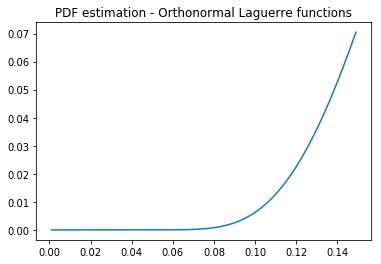

In [11]:
#------ Approximation 2 - Orthonormal Laguerre functions --------

#q estimation

regul = 1;
H     = np.zeros([TE_measurements.size, TE_measurements.size])
nn    = np.arange(0,TE_measurements.size)

for i,TE in enumerate(TE_measurements):
    H[i,:] = TE**nn/(TE+1)**(nn+1)
    
q = np.matmul(np.linalg.inv(np.matmul(H.transpose(),H)+regul*np.identity(TE_measurements.size)),np.matmul(H.transpose(),S))

# PDF estimation
f = np.zeros(T2_signal.size)

for i,current_T2 in enumerate(T2_signal):
    for n,qn in enumerate(q):
        tmp = 0 
        for k in range(n+1):
            tmp+= special.comb(n,k)*((-1/current_T2)**k)/np.math.factorial(k)
        f[i] +=(qn*tmp)
    f[i]*= np.exp(-1/current_T2)/(current_T2**2)
    
plt.plot(T2_signal,f)
plt.title('PDF estimation - Orthonormal Laguerre functions')
plt.show()

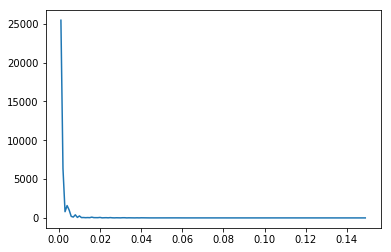

In [12]:
#------ Approximation 3 - Fourier cosine series --------

#q estimation
regul  = 1e-6;
H      = np.zeros([TE_measurements.size, TE_measurements.size])
H[:,0] = 1/2/TE_measurements

L      = np.min(T2_signal)

for i,current_TE in enumerate(TE_measurements):
    for n in range(1,TE_measurements.size):
        H[i,n] = current_TE/(current_TE**2+(n*np.pi/L)**2)

q = np.matmul(np.linalg.inv(np.matmul(H.transpose(),H)+regul*np.identity(TE_measurements.size)),np.matmul(H.transpose(),S))

#pdf

f = np.zeros(T2_signal.size)

for ii,current_T2 in enumerate(T2_signal):
    for n,qn in enumerate(q):
        if n==0:
            f[ii] +=qn/2
        else:
            f[ii] +=qn*np.cos(n*np.pi/L/current_T2)
    f[ii]/=(current_T2**2)
    
plt.plot(T2_signal,f)
plt.show()
